In [1]:
import cmasher as cmr
import matplotlib as mpl

# Access rainforest colormap through CMasher or MPL
cmap = cmr.rainforest                   # CMasher
cmap = mpl.colormaps['cmr.seaweed']  # MPL

In [2]:
import os
import numpy as np
import re
import pickle
import sys
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import datetime 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import json
from statsmodels.graphics.mosaicplot import mosaic

sys.path.insert(1, '../')
from SeasonalPlot_Functions import *

from MasterPlot_Functions import *

In [3]:
def make_plot(df_changes_all, df_changes_byduration, variable, cmap, low_lim = None, high_lim=None):

    fig, axes = plt.subplots(3, 4, figsize=(16, 11))

    #################################################
    # Present
    #################################################
    variable_to_plot = f'{variable}_present'

    # Get all data
    present_data = df_changes_all[['gauge_num', variable_to_plot]].copy()
    present_data['Climate'] = 'present'  # Add a Climate column for clarity   
    
    if high_lim == None:
        low_lim=present_data[variable_to_plot].min()
        high_lim=present_data[variable_to_plot].max()
    print(low_lim, high_lim)
    
    # Plot for each duration
    this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(1)][['gauge_num', variable_to_plot]]
    # low_lim=this_duration['R_present'].min()
    # high_lim=this_duration['R_present'].max()
    plot_values_on_map(axes[0,0], this_duration, '1h', tbo_vals,
                       variable_to_plot, low_lim, high_lim, cmap)

    this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(6)][['gauge_num', variable_to_plot]]
    # low_lim=this_duration['R_present'].min()
    # high_lim=this_duration['R_present'].max()
    plot_values_on_map(axes[0,1], this_duration, '6h', tbo_vals, 
                       variable_to_plot, low_lim, high_lim, cmap)

    this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(24)][['gauge_num', variable_to_plot]]
    # low_lim=this_duration['R_present'].min()
    # high_lim=this_duration['R_present'].max()
    plot_values_on_map(axes[0,2], this_duration, '24h', tbo_vals, 
                       variable_to_plot, low_lim, high_lim, cmap=cmap)  

    ### Plot 'All' values
    plot_values_on_map(axes[0,3], present_data, 'All', tbo_vals, 
                       variable_to_plot, vmin=low_lim, vmax=high_lim, cmap=cmap)

    #################################################
    # Future
    #################################################   
    variable_to_plot = f'{variable}_future'
    
    future_data = df_changes_all[['gauge_num', variable_to_plot]].copy()
    future_data['Climate'] = 'future'  # Add a Climate column for clarity   
    
    if high_lim == None:
        low_lim=future_data[variable_to_plot].min()
        high_lim=future_data[variable_to_plot].max()

    # Plot for each duration
    this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(1)][['gauge_num', variable_to_plot]]
    plot_values_on_map(axes[1,0], this_duration, '1h', tbo_vals,
                       variable_to_plot, low_lim, high_lim, cmap)

    this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(6)][['gauge_num', variable_to_plot]]
    plot_values_on_map(axes[1,1], this_duration, '6h', tbo_vals, 
                       variable_to_plot, low_lim, high_lim, cmap)

    this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(24)][['gauge_num', variable_to_plot]]
    plot_values_on_map(axes[1,2], this_duration, '24h', tbo_vals, 
                       variable_to_plot, low_lim, high_lim, cmap=cmap)    


    ### Plot 'All' values
    plot_values_on_map(axes[1,3], future_data, 'All', tbo_vals, 
                       variable_to_plot, vmin=low_lim, vmax=high_lim, cmap=cmap)


    #################################################
    # Difference
    #################################################
    variable_to_plot = f'{variable}_diff'

    ## All
    diff_data = df_changes_all[['gauge_num', variable_to_plot]].copy()
    diff_data['Climate'] = 'present'  # Add a Climate column for clarity    
    
    low_lim=diff_data[variable_to_plot].min()
    high_lim=diff_data[variable_to_plot].max()
    cmap = 'bwr'

    ## By duration
    this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(1)][['gauge_num', variable_to_plot]]
    plot_values_on_map(axes[2,0], this_duration, '1h', tbo_vals,
                       variable_to_plot, low_lim, high_lim, 'bwr')

    this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(6)][['gauge_num', variable_to_plot]]
    plot_values_on_map(axes[2,1], this_duration, '6h', tbo_vals, 
                       variable_to_plot, low_lim, high_lim, 'bwr')

    this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(24)][['gauge_num', variable_to_plot]]
    plot_values_on_map(axes[2,2], this_duration, '24h', tbo_vals, 
                       variable_to_plot, low_lim, high_lim, cmap='bwr')    

    # Plot all
    plot_values_on_map(axes[2,3], diff_data, 'All', tbo_vals, 
                       variable_to_plot, vmin=low_lim, vmax=high_lim, cmap='bwr')

    fig.text(0.08, 0.750, 'Present', va='center', ha='center', fontsize=12, rotation='horizontal');
    fig.text(0.08, 0.5, 'Future', va='center', ha='center', fontsize=12, rotation='horizontal');
    fig.text(0.08, 0.22, 'Difference', va='center', ha='center', fontsize=12, rotation='horizontal');

    plt.suptitle(f'{variable} of events at each gauge, split by sampling duration', fontsize=16);    

def plot_values_on_map(ax, data, title, tbo_vals, value_column, vmin, vmax, cmap='viridis'):
    
    gauge_locs = data['gauge_num'].copy()

    # Now index into gauge_locations with the copied values
    lon = tbo_vals.loc[gauge_locs, 'Lon']
    lat = tbo_vals.loc[gauge_locs, 'Lat']
    
    # Plot the background outline of Great Britain
    gb_outline.plot(ax=ax, color='darkgrey', edgecolor='black', linewidth=1)
    
    # Scatter plot for the specified value column
    scatter = ax.scatter(lon, lat, c=data[value_column], cmap=cmap, edgecolor=None, alpha=0.9, s=6, 
                         vmin =vmin, vmax=vmax)
    ax.set_title(title)
    #ax.set_xlabel('Longitude')
    #ax.set_ylabel('Latitude')
    ax.set_xticklabels([]); ax.set_yticklabels([])
    
    # Create a color bar that is scaled to the size of the plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)  # Control the width and padding of the colorbar
    plt.colorbar(scatter, cax=cax)   
    

In [4]:
home_dir = '/nfs/a319/gy17m2a/PhD/'
home_dir2 = '/nfs/a161/gy17m2a/PhD/'

In [5]:
tbo_vals = pd.read_csv(home_dir + 'datadir/RainGauge/interarrival_thresholds_CDD_noMissing.txt')
tbo_vals = tbo_vals[tbo_vals['Lon']!=-999.0]
tbo_vals['gauge_num'] = tbo_vals.index

### Load and prepare data

#### All events data

In [7]:
df_long=pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/all_events_characteristics.csv")
# df_long['dur_for_which_this_is_amax'] = df_long['dur_for_which_this_is_amax'].apply(json.loads)

present=df_long[df_long['Climate']=='Present']
future=df_long[df_long['Climate']=='Future']
nimrod = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/NIMROD_30mins/all_events_characteristics.csv")

#### Change data

In [24]:
df_changes_all = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_changes_allevents.csv")
df_changes_all_season = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_season_changes_allevents.csv")
df_changes_byduration = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_changes_bydur.csv")
df_changes_byduration_season = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_season_changes_bydur.csv")

In [26]:
df_changes_byduration['D_mean_present'].max()

250.30263157894737

#### Seasonal splits

In [9]:
df_changes_summer = df_changes_all_season[df_changes_all_season['season']=='Summer']
df_changes_byduration_summer = df_changes_byduration_season[df_changes_byduration_season['season']=='Summer']

df_changes_winter = df_changes_all_season[df_changes_all_season['season']=='Winter']
df_changes_byduration_winter = df_changes_byduration_season[df_changes_byduration_season['season']=='Winter']

# summer = df_changes_all_season[df_changes_all_season['season']=='Summer']
# summer_by_duration = df_changes_byduration_season[df_changes_byduration_season['season']=='Summer']

# summer = df_changes_all_season[df_changes_all_season['season']=='Summer']
# summer_by_duration = df_changes_byduration_season[df_changes_byduration_season['season']=='Summer']

# Seasonality of events
## Compare seasonal distribution for different durations AND between present and future

In [ ]:
# List of durations and corresponding subplot titles
durations = ['1',  '6', "24"] # ['0.5', '1', '2', '3', '6',"12", '24']
titles = [f"{i}hr" for i in durations]

##########################################################
## present
##########################################################
fig, axes = plt.subplots(3, 4, figsize=(18, 12), subplot_kw={'polar': True})

# # Loop through durations, axes, and titles
for ax_num, (duration, title) in enumerate(zip(durations, titles)):
    this_duration = present[present['dur_for_which_this_is_amax'].apply(
        lambda x: isinstance(x, list) and str(duration) in x or x == str(duration))]
    plot_polar_months_plot(this_duration, axes[0, ax_num], True, title, 25, name_variable_to_plot='Percentage')
plot_polar_months_plot(present, axes[0, 3], True, "All",25, name_variable_to_plot = 'Percentage')    
fig.text(0.06, 0.75, 'Present', va='center', ha='center', fontsize=18, rotation='horizontal');

##########################################################
## Future
##########################################################
for ax_num, (duration, title) in enumerate(zip(durations, titles)):
    this_duration = future[future['dur_for_which_this_is_amax'].apply(
        lambda x: isinstance(x, list) and str(duration) in x or x == str(duration))]
    plot_polar_months_plot(this_duration, axes[1,ax_num], False, title, 25, name_variable_to_plot='Percentage')
plot_polar_months_plot(future, axes[1,3], False, "Present (all)",25, name_variable_to_plot = 'Percentage')    
fig.text(0.06, 0.50, 'Future', va='center', ha='center', fontsize=18, rotation='horizontal');


# ##########################################################
# ## Present and future overlaid
# ##########################################################
for ax_num, (duration, title) in enumerate(zip(durations, titles)):
    this_duration_pres = present[present['dur_for_which_this_is_amax'].apply(
        lambda x: isinstance(x, list) and str(duration) in x or x == str(duration))]
    this_duration_future = future[future['dur_for_which_this_is_amax'].apply(
        lambda x: isinstance(x, list) and str(duration) in x or x == str(duration))]
    plot_polar_months_plot_overlay(this_duration_pres, this_duration_future, axes[2, ax_num], False, 'All', False, 25) 
plot_polar_months_plot_overlay(present, future, axes[2, 3], False, 'All', True, 25) 
fig.text(0.06, 0.25, 'Change', va='center', ha='center', fontsize=18, rotation='horizontal');

## Day of year and R values 
For each gauge we can calculate:  
    - The mean day of year that events occur  
    - The R value of events - a measure of how dispersed/concentrated events are within a year  

### Day of year - present, future, change

In [ ]:
make_plot(df_changes_all, df_changes_byduration, 'D_mean','Blues' )

###  R (how dispersed events are) - present, future change

In [ ]:
make_plot(df_changes_all, df_changes_byduration, 'R', 'inferno')

# Loading analysis

Should this be a diverging colour ramp to highlight values which are above or below 50? need to fix 50 as the centre if so

In [ ]:
make_plot(df_changes_all, df_changes_byduration, 'D50_mean', 'RdYlGn') # PiYG #PuBuGn

In [ ]:
make_plot(df_changes_all,df_changes_byduration, 'D50_median', 'RdYlGn')

## Distribution of values

In [ ]:
# Plot KDE for present and future D50
sns.kdeplot(present['D50_new'], label='Present', color='blue', shade=False)
sns.kdeplot(future['D50_new'], label='Future', color='orange', shade=False)

# Add labels and title
plt.xlabel('D50')
plt.ylabel('Density')
plt.title('KDE of D50 - Present vs Future')
plt.legend()

# Show plot
plt.show()


In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10,6), sharey=True)

axes[0].hist(present['D50_new'], bins=50, alpha=0.5, label='Present', color='blue', density=True)
axes[0].hist(future['D50_new'], bins=50, alpha=0.5, label='Future', color='orange', density=True)
axes[0].set_xlabel('D50')
axes[0].set_ylabel('Density')
axes[0].legend(); 

# Plot KDE for present and future D50
sns.kdeplot(present['D50_new'], label='Present', color='blue', shade=False, ax=axes[1])
sns.kdeplot(future['D50_new'], label='Future', color='orange', shade=False, ax=axes[1])
axes[1].set_xlabel('D50')
axes[1].legend(); 

In [ ]:
make_plot(df_changes_all,df_changes_byduration, 'F2_percentage', 'Blues') # PiYG #PuBuGn

In [ ]:
make_plot(df_changes_all,df_changes_byduration, 'B2_percentage', 'Reds') # PiYG #PuBuGn

In [ ]:
# make_plot(df_changes_all, df_changes_byduration, 'F2_percentage', 'viridis') # PiYG #PuBuGn
# make_plot(df_changes_all, df_changes_byduration, 'B2_percentage', 'viridis') # PiYG #PuBuGn
make_plot(df_changes_summer,df_changes_byduration_summer, 'D50_P90', 'viridis', 80, 90) # PiYG #PuBuGn
make_plot(df_changes_all,df_changes_byduration, 'D50_P10', 'RdYlGn') # PiYG #PuBuGn

## Roberto style analysis

In [ ]:
quintile_mapping = {1: 'F2', 2: 'F1', 3: 'C', 4: 'B1', 5: 'B2'}
quintile_mapping_thirds = {1: 'F', 2: 'C', 3: 'B'}
quintile_cats = ['F2','F1', 'C', 'B1', 'B2']
color_mapping = {'F2': (0.0, 0.0, 1.0, 0.6),   'F1': (0.0, 0.6902, 1.0, 0.6),
    'C': (0.5, 0.5, 0.5, 0.6), 'B1': (0.8039, 0.0, 0.0, 0.6),'B2': (0.5451, 0.0, 0.0, 0.6)} 

In [ ]:
my_dict = {'Present (UKCP18)' :present, 'Future (UKCP18)':future,
           'NIMROD':nimrod}
short_ids = ['Present (UKCP18)', 'Future (UKCP18)', 'NIMROD']

# Create the subplots
fig, axs = plt.subplots(nrows=len(short_ids), figsize=(16, 3), sharex=True)

# Loop over each id and create the plots
for i, id in enumerate(short_ids):
    create_single_variable_mosaic_plot_pctlabels(axs[i], my_dict[id], 'Loading_profile_molly', 
        quintile_cats, color_mapping,  short_ids[i])

## Add version for different durations

## Comparing methods

In [ ]:
df_long = df_long.sort_values('Loading_profile_molly')
df_long = df_long.sort_values('Loading_profile_molly', key=lambda s: s.apply(['F2', 'F1', 'C', 'B1', 'B2'].index), ignore_index=True)

present = present.sort_values('Loading_profile_molly', key=lambda s: s.apply(['F2', 'F1', 'C', 'B1', 'B2'].index), ignore_index=True)
future = future.sort_values('Loading_profile_molly', key=lambda s: s.apply(['F2', 'F1', 'C', 'B1', 'B2'].index), ignore_index=True)

In [ ]:
fig, axs = plt.subplots(figsize=(8,6))
plot_boxplot(df_long[['Loading_profile_molly', 'D50']], axs, color_mapping)
plt.show()

### Change order of seasons!!!

In [ ]:
# Define custom order for Loading_profile_molly and season
loading_order = ['F2', 'F1', 'C', 'B1', 'B2']
season_order = [  'Spring', 'Summer', 'Autumn','Winter',]

# Create a mapping for custom orders
loading_mapping = {value: index for index, value in enumerate(loading_order)}
season_mapping = {value: index for index, value in enumerate(season_order)}

# Add new columns to the DataFrame for sorting
present['Loading_order'] = present['Loading_profile_molly'].map(loading_mapping)
present['Season_order'] = present['season'].map(season_mapping)

# Sort the DataFrame by the new order columns
present = present.sort_values(by=['Loading_order', 'Season_order'], ignore_index=True)

# Drop the temporary sorting columns
present = present.drop(columns=['Loading_order', 'Season_order'])

In [ ]:
def plot_boxplot_by_duration(data, ax):
    sns.boxplot(ax=ax, data=data, x='Loading_profile_molly',
            y='d',  hue='duration', dodge=True, palette = season_palette)           

In [ ]:
fig, axs = plt.subplots(figsize=(12,8))
plot_boxplot_by_season(present[['Loading_profile_molly', 'D50', 'season']], axs)
plt.show()

In [ ]:
# h1 = df_long[df_long['sampling_duration'] == float(1)]

# h6 = df_long[df_long['sampling_duration'] == float(6)]

# h24 = df_long[df_long['sampling_duration'] == float(24)]

In [ ]:
# fig, axs = plt.subplots(figsize=(12,8))
# plot_boxplot_by_duration(df_changes_byduration[['Loading_profile_molly', 'D50', 'sampling_duration']], axs)
# plt.show()

### D50 vs Tb0

In [ ]:
tbo_vals = pd.read_csv('/nfs/a319/gy17m2a/PhD/datadir/RainGauge/interarrival_thresholds_CDD_noMissing.txt')
tbo_vals['gauge_num']=tbo_vals.index

df_merged = pd.merge(df_long, tbo_vals[['gauge_num', 'Critical_interarrival_time']], on='gauge_num', how='left')

In [ ]:
df_merged = pd.merge(df_changes_all, tbo_vals[['gauge_num', 'Critical_interarrival_time']], on='gauge_num', how='left')

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(10,8), sharey=True)
ax[0].scatter(df_merged['D_mean_present'], df_merged['Critical_interarrival_time'])
ax[0].set_xlabel('D50 mean')
ax[0].set_ylabel('Tb0')

# ax[0].scatter(df_changes_all['D50_mean_present'], df_changes_all['theta_mean_future'])
ax[1].scatter(df_merged['D_mean_present'], df_merged['Critical_interarrival_time'])
ax[1].set_xlabel('D50 mean')
# ax[1].set_ylabel('Theta');

### D50 vs Theta

More back-loaded events later in the year...  
But it's a gauge summary, so actually it's saying that gauges that tend to have AMAX events later in the year, also tend to have more back-loaded vents

In [13]:
from scipy.stats import gaussian_kde, linregress
def plot_contour(ax, data_x, data_y, title, cmap='Blues'):
    # Create a grid for the contour plot
    x_grid = np.linspace(data_x.min(), data_x.max(), 100)
    y_grid = np.linspace(data_y.min(), data_y.max(), 100)
    X, Y = np.meshgrid(x_grid, y_grid)

    # Perform Kernel Density Estimation (KDE)
    kde = gaussian_kde([data_x, data_y])
    Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

    # Normalize the density values to be between 0 and 1
    Z_normalized = (Z - Z.min()) / (Z.max() - Z.min())

    # Create the contour plot with fixed color limits between 0 and 1
    contour = ax.contourf(X, Y, Z_normalized, levels=10, cmap=cmap, alpha=0.6, vmin=0, vmax=1)
    cbar = fig.colorbar(contour, ax=ax)
    cbar.set_label('Density (normalized)')

    # Set labels
    if ax ==axs[1,0] or ax == axs[1,1]:
        ax.set_xlabel('%')
    ax.set_ylabel('Earlier in year <--> Later in year')
    ax.set_title(title)

In [41]:
df_changes_all["D_mean_present"].to_csv("D_mean_present.csv")
df_changes_all["D_mean_future"].to_csv("D_mean_future.csv")
df_changes_byduration["D_mean_present"].to_csv("D_mean_present_bydur.csv")
df_changes_byduration["D_mean_future"].to_csv("D_mean_future_bydur.csv")

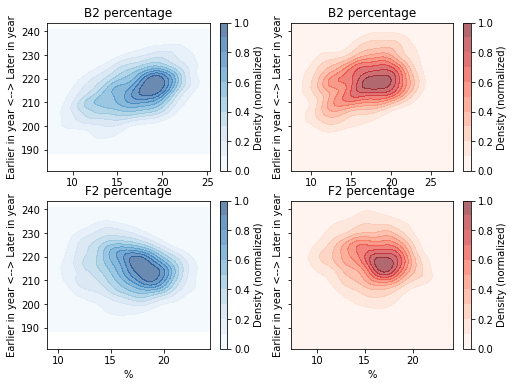

In [19]:
fig, axs = plt.subplots(ncols=2,nrows=2, figsize=(8, 6), sharey=True)    

plot_contour(axs[1,0], df_changes_all['F2_percentage_present'], df_changes_all['D_mean_present'], 'F2 percentage', )
plot_contour(axs[1,1], df_changes_all['F2_percentage_future'], df_changes_all['D_mean_future'], 'F2 percentage', 'Reds')

plot_contour(axs[0,0], df_changes_all['B2_percentage_present'], df_changes_all['D_mean_present'], 'B2 percentage', )
plot_contour(axs[0,1], df_changes_all['B2_percentage_future'], df_changes_all['D_mean_future'], 'B2 percentage', 'Reds')

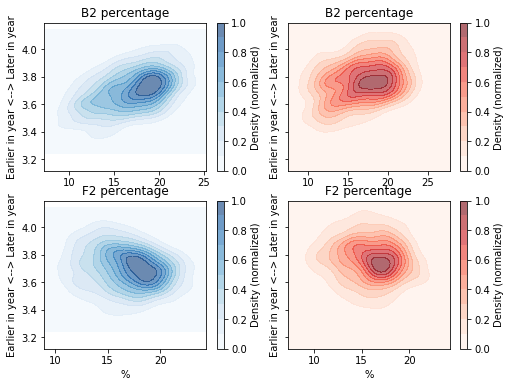

In [173]:
fig, axs = plt.subplots(ncols=2,nrows=2, figsize=(8, 6), sharey=True)    

plot_contour(axs[1,0], df_changes_all['F2_percentage_present'], df_changes_all['theta_mean_present'], 'F2 percentage', )
plot_contour(axs[1,1], df_changes_all['F2_percentage_future'], df_changes_all['theta_mean_future'], 'F2 percentage', 'Reds')

plot_contour(axs[0,0], df_changes_all['B2_percentage_present'], df_changes_all['theta_mean_present'], 'B2 percentage', )
plot_contour(axs[0,1], df_changes_all['B2_percentage_future'], df_changes_all['theta_mean_future'], 'B2 percentage', 'Reds')

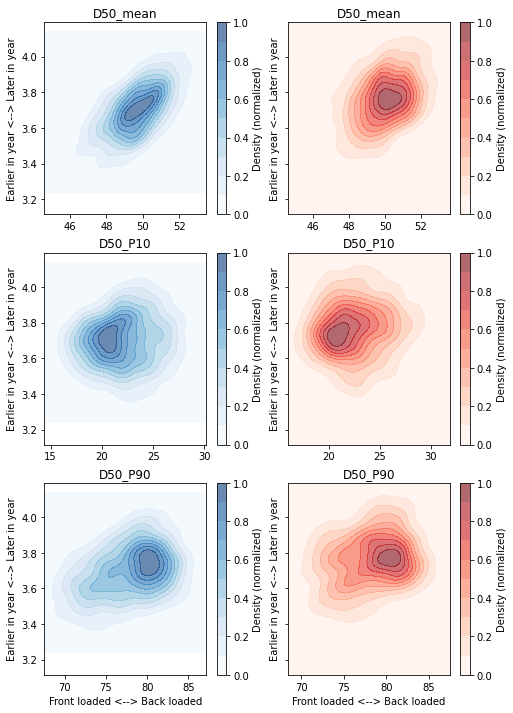

In [170]:
fig, axs = plt.subplots(ncols=2,nrows=3, figsize=(8, 12), sharey=True)    
plot_contour(axs[0,0], df_changes_all['D50_mean_present'], df_changes_all['theta_mean_present'],'D50_mean', )
plot_contour(axs[0,1], df_changes_all['D50_mean_future'], df_changes_all['theta_mean_future'], 'D50_mean', 'Reds')

plot_contour(axs[1,0], df_changes_all['D50_P10_present'], df_changes_all['theta_mean_present'],'D50_P10')
plot_contour(axs[1,1], df_changes_all['D50_P10_future'], df_changes_all['theta_mean_future'], 'D50_P10', 'Reds')

plot_contour(axs[2,0], df_changes_all['D50_P90_present'], df_changes_all['theta_mean_present'], 'D50_P90', )
plot_contour(axs[2,1], df_changes_all['D50_P90_future'], df_changes_all['theta_mean_future'], 'D50_P90', 'Reds')

# plot_contour(axs[3,0], df_changes_all['B2_percentage_present'], df_changes_all['theta_mean_present'], 'F2 percentage', )
# plot_contour(axs[3,1], df_changes_all['B2_percentage_future'], df_changes_all['theta_mean_future'], 'F2 percentage', 'Reds')

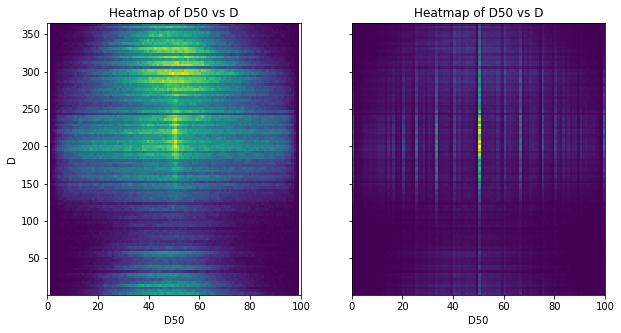

In [39]:
fig, axs = plt.subplots(ncols = 2,  sharey=True, sharex=True, figsize=(10, 5))

axs[0].hist2d(df_long['D50_new'].values, df_long['D'].values,  bins=100, cmap='viridis')  # You can choose a different color map
axs[0].set_xlabel('D50')
# axs[0].set_colorbar(label='Density')
axs[0].set_ylabel('D')
axs[0].set_title('Heatmap of D50 vs D')

axs[1].hist2d(df_long['D50'].values, df_long['D'].values,  bins=100, cmap='viridis')  # You can choose a different color map
axs[1].set_xlabel('D50')
# axs[1].set_ylabel('D')
axs[1].set_title('Heatmap of D50 vs D');

NameError: name 'normalized_hist' is not defined

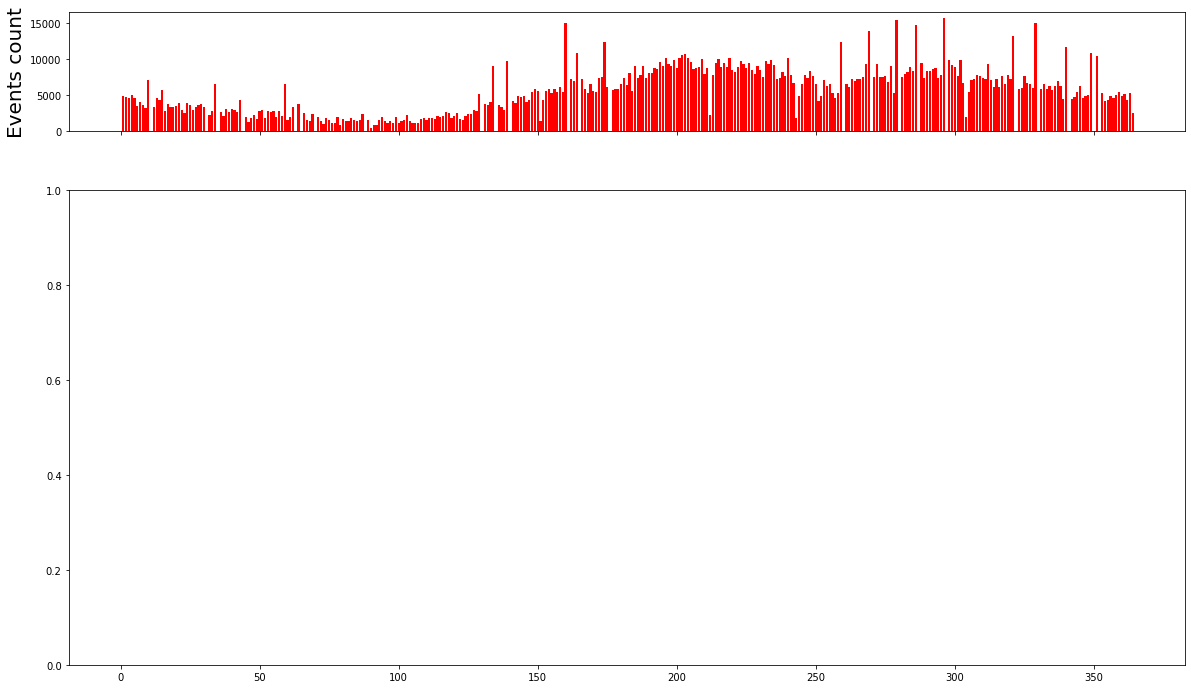

In [14]:
# 1. Define bins for 'D50'
D50_bins = np.linspace(present['D50_new'].min(), present['D50_new'].max(), 50) 

# 2. Create a 2D histogram to count events for each D50 vs D combination
hist, D50_edges, D_edges = np.histogram2d(df_long['D50_new'].values, df_long['D'].values, bins=[D50_bins, np.arange(0, 366)])

# Example histogram creation (already done in previous code)
D_counts = hist.sum(axis=0)  # Total number of events per day (summed across all D50 bins)

# 1. Create a figure with two subplots (stacked vertically)
fig, (ax_count, ax_heatmap) = plt.subplots(2, 1, figsize=(20, 12), gridspec_kw={'height_ratios': [1, 4]}, sharex=True)

# 2. Plot the event counts (number of events per day) as a line plot on the first subplot
ax_count.bar(np.arange(0, 365), D_counts, color='red', linewidth=2)
ax_count.set_ylabel('Events count', fontsize=20)
# ax_count.set_title('')

# 3. Plot the normalized 2D histogram (proportions per day) as a heatmap on the second subplot
cax = ax_heatmap.imshow(normalized_hist, origin='lower', aspect='auto', extent=[0, 365, D50_bins[0], D50_bins[-1]], cmap='Reds')

# Add colorbar to the heatmap
# cbar = fig.colorbar(cax, ax=ax_heatmap)
# cbar.set_label('Proportion of Events')

# 4. Label the heatmap axes
ax_heatmap.set_xlabel('Day of Year (D)', fontsize=20)
ax_heatmap.set_ylabel('D50', fontsize=20)
# ax_heatmap.set_title('Proportion of Events by Day of Year and D50')

ax_heatmap.tick_params(axis='both', which='major', labelsize=15)  
ax_count.tick_params(axis='both', which='major', labelsize=15)  

# Tight layout for better spacing between plots
plt.tight_layout()

plt.show()


### Comparing distributions

In [204]:
present_summer = present[present['season']=="Summer"]

In [205]:
present_05h = present_summer[present_summer['dur_for_which_this_is_amax'].apply(
    lambda x: isinstance(x, list) and str(0.5) in x or x == str(0.5))]
future_05h = future[future['dur_for_which_this_is_amax'].apply(
    lambda x: isinstance(x, list) and str(0.5) in x or x == str(0.5))]

present_1h = present_summer[present_summer['dur_for_which_this_is_amax'].apply(
    lambda x: isinstance(x, list) and str(1) in x or x == str(1))]
future_1h = future[future['dur_for_which_this_is_amax'].apply(
    lambda x: isinstance(x, list) and str(1) in x or x == str(1))]

present_6h = present_summer[present_summer['dur_for_which_this_is_amax'].apply(
    lambda x: isinstance(x, list) and str(6) in x or x == str(6))]
future_6h = future[future['dur_for_which_this_is_amax'].apply(
    lambda x: isinstance(x, list) and str(6) in x or x == str(6))]

present_24h = present_summer[present_summer['dur_for_which_this_is_amax'].apply(
    lambda x: isinstance(x, list) and str(24) in x or x == str(24))]
future_24h = future[future['dur_for_which_this_is_amax'].apply(
    lambda x: isinstance(x, list) and str(24) in x or x == str(24))]

In [215]:
vals, counts = np.unique(present_24h['duration'], return_counts=True)
test=pd.DataFrame({'vals':vals, 'counts':counts})
test.sort_values(by="counts", ascending=False)[:15]

,vals,counts
44,23.5,3841
46,24.5,3175
45,24.0,3146
43,23.0,2983
42,22.5,2466
41,22.0,2302
0,1.5,2113
40,21.5,2104
39,21.0,1936
47,25.0,1934


In [230]:
test=pd.read_csv(home_dir2+'ProcessedData/IndependentEvents/UKCP18_30mins/Present/bc006/1051/WholeYear/EventSet/0.5hrs_2007_v2_part0.csv')
pd.set_option('display.float_format', lambda x: '%.6f' % x)
test

,Unnamed: 0,precipitation (mm/hr),times,precipitation (mm),is_dry,Rolling_Sum,consecutive_dry
0,8857,0.000001,2007-07-05 12:45:00,0.000000,True,0.000000,1.000000
1,8858,51.130543,2007-07-05 13:15:00,25.565271,False,25.565271,NaN
2,8859,47.465970,2007-07-05 13:45:00,23.732985,False,23.732985,NaN
3,8860,2.836937,2007-07-05 14:15:00,1.418468,False,1.418468,NaN


In [231]:
test=pd.read_csv(home_dir2+'ProcessedData/IndependentEvents/UKCP18_30mins/Present/bc006/1051/WholeYear/EventSet/24hrs_2007_v2_part0.csv')
pd.set_option('display.float_format', lambda x: '%.6f' % x)
test

,Unnamed: 0,precipitation (mm/hr),times,precipitation (mm),is_dry,Rolling_Sum,consecutive_dry
0,8815,0.000017,2007-07-04 15:45:00,0.000008,True,0.000050,1.000000
1,8816,0.000005,2007-07-04 16:15:00,0.000002,True,0.000052,2.000000
2,8817,0.000001,2007-07-04 16:45:00,0.000001,True,0.000052,3.000000
3,8818,0.648433,2007-07-04 17:15:00,0.324217,False,0.324269,0.000000
4,8819,1.002149,2007-07-04 17:45:00,0.501074,False,0.825343,0.000000
5,8820,0.515695,2007-07-04 18:15:00,0.257848,False,1.083189,0.000000
6,8821,0.074178,2007-07-04 18:45:00,0.037089,True,1.120278,1.000000
7,8822,1.770649,2007-07-04 19:15:00,0.885324,False,2.005601,0.000000
8,8823,3.633814,2007-07-04 19:45:00,1.816907,False,3.822508,0.000000
9,8824,6.072904,2007-07-04 20:15:00,3.036452,False,6.858959,0.000000


In [216]:
present_24h[present_24h['duration']==1.5]

,season,duration,DurationRange_personalised_allems,DurationRange_notpersonalised,DurationRange_simple,year,month,Volume,max_intensity,max_quintile_molly,...,D50_new,com,dur_for_which_this_is_amax,gauge_num,area,em,filename,Climate,D,date
35000,Summer,1.5,0.25-2.10 hr,0.25-2.10 hr,<4hr,2011,7,7.553202,11.960560,1,...,21.050301,0.108187,[24],1048,NW,bc006,24hrs_2011_v2_part0.csv,Present,186.0,2011-07-05
35115,Summer,1.5,0.25-2.10 hr,0.25-2.10 hr,<4hr,2004,7,3.297006,3.346774,1,...,32.837651,0.265274,[24],1053,NE,bc006,24hrs_2004_v2_part0.csv,Present,203.0,2004-07-21
35176,Summer,1.5,0.25-2.10 hr,0.25-2.10 hr,<4hr,2007,7,50.716724,51.130542,1,...,33.063555,0.174630,"[0.5, 1, 24, 2, 3, 6]",1051,NW,bc006,0.5hrs_2007_v2_part0.csv,Present,186.0,2007-07-05
35194,Summer,1.5,0.25-2.10 hr,0.25-2.10 hr,<4hr,2016,7,45.610591,52.022426,1,...,29.224955,0.148771,"[0.5, 12, 1, 24, 2, 3, 6]",438,SW,bc013,0.5hrs_2016_v2_part0.csv,Present,200.0,2016-07-18
35429,Summer,1.5,0.25-2.10 hr,0.25-2.10 hr,<4hr,2015,9,59.912031,59.809452,1,...,33.395736,0.181474,"[0.5, 12, 1, 24, 2, 3, 6]",253,SE,bc012,0.5hrs_2015_v2_part0.csv,Present,257.0,2015-09-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991992,Summer,1.5,0.25-2.10 hr,0.25-2.10 hr,<4hr,2010,8,0.602375,0.782603,5,...,74.343084,0.487201,[24],764,NW,bc010,24hrs_2010_v2_part1.csv,Present,225.0,2010-08-13
992032,Summer,1.5,0.25-2.10 hr,0.25-2.10 hr,<4hr,2006,9,0.840724,0.858313,5,...,67.349742,0.354200,[24],1161,NW,bc016,24hrs_2006_v2_part1.csv,Present,263.0,2006-09-20
992446,Summer,1.5,0.25-2.10 hr,0.25-2.10 hr,<4hr,2013,7,1.068347,0.896109,5,...,56.920916,0.371496,[24],1177,NE,bc016,24hrs_2013_v2_part1.csv,Present,188.0,2013-07-07
993357,Summer,1.5,0.25-2.10 hr,0.25-2.10 hr,<4hr,2015,8,0.742560,0.847531,5,...,70.795189,0.490957,[24],817,SE,bc010,24hrs_2015_v2_part1.csv,Present,213.0,2015-08-01


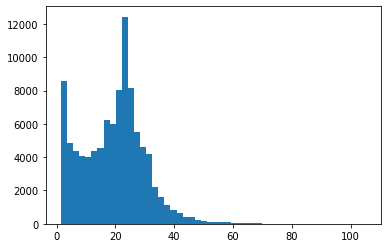

In [211]:
plt.hist(present_24h['duration'], bins=50);

Text(0, 0.5, 'D50')

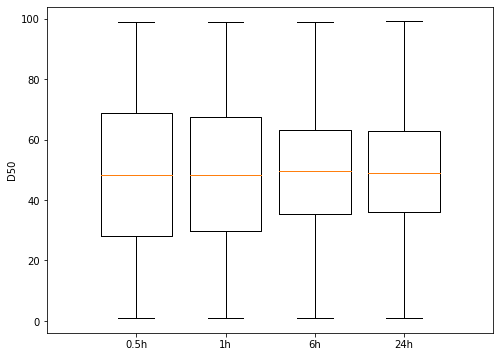

In [201]:
# Create box plots for the two distributions
plt.figure(figsize=(8, 6))
plt.boxplot([present_05h['D50_new'], present_1h['D50_new'], present_6h['D50_new'], present_24h['D50_new']], 
            positions=[1, 1.5, 2, 2.5],  # Adjust the positions to be closer together
            widths=0.4)          # Optional: Set width of boxes for better visibility
plt.xticks([1, 1.5, 2, 2.5], ['0.5h', '1h', '6h', '24h'])  # Set x-tick labels

# Add labels and title
plt.ylabel('D50')

In [172]:
from scipy.stats import ks_2samp

# Perform KS test
ks_stat, p_value = ks_2samp(present['D50_new'], future['D50_new'])

print(f"KS Statistic: {ks_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("The distributions are significantly different.")
else:
    print("The distributions are not significantly different.")

KS Statistic: 0.006551483283587789
P-value: 4.6242267277612685e-18
The distributions are significantly different.


In [96]:
bc005 = present[present['em']=='bc005']
bc006 = present[present['em']=='bc006']
bc007 = present[present['em']=='bc007']
bc009 = present[present['em']=='bc009']
bc010 = present[present['em']=='bc010']
bc011 = present[present['em']=='bc011']
bc013 = present[present['em']=='bc013']

In [101]:
from scipy.stats import ks_2samp

# Perform KS test
ks_stat, p_value = ks_2samp(bc005['D50_new'], bc011['D50_new'])

print(f"KS Statistic: {ks_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("The distributions are significantly different.")
else:
    print("The distributions are not significantly different.")

KS Statistic: 0.04758583370036962
P-value: 2.05151235372368e-89
The distributions are significantly different.


In [42]:
def make_contour_plot(df_changes_byduration, df_changes_all, variable):
    
    durations =[1,6,24]

    df_changes_all_test =df_changes_all.copy()
    df_changes_byduration_test = df_changes_byduration.copy()
    
    df_changes_all_test["D_mean_present"] = df_changes_all_test["D_mean_present"].apply(lambda x: x + 365 if x < 50 else x)
    df_changes_all_test["D_mean_future"] = df_changes_all_test["D_mean_future"].apply(lambda x: x + 365 if x < 50 else x)
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharey=False, sharex=False, gridspec_kw={'hspace': 0.2, 'wspace':0.14})
    
    for ax_num, (duration, title) in enumerate(zip(durations, durations)):
        this_duration = df_changes_byduration_test[df_changes_byduration_test['sampling_duration'] == float(duration)].copy()
        this_duration["D_mean_present"] = this_duration["D_mean_present"].apply(lambda x: x + 365 if x < 50 else x)
        plot_contour(fig, axes[0, ax_num], this_duration['D_mean_present'],this_duration[f'{variable}_present'], "Day of year", f"{variable[:2]} %", f"{duration}hrs" )
    plot_contour(fig, axes[0, 3], df_changes_all_test["D_mean_present"],  df_changes_all_test[f'{variable}_present'],"Day of year", f"{variable[:2]} %", "All"  )
    fig.text(0.04, 0.7, 'Present', va='center', ha='center', fontsize=18, rotation='horizontal');
    
    for ax_num, (duration, title) in enumerate(zip(durations, durations)):
        this_duration = df_changes_byduration_test[df_changes_byduration_test['sampling_duration'] == float(duration)].copy()
        this_duration["D_mean_future"] = this_duration["D_mean_future"].apply(lambda x: x + 365 if x < 50 else x)
        plot_contour(fig, axes[1, ax_num], this_duration['D_mean_future'], this_duration[f'{variable}_future'], "Day of year", f"{variable[:2]} %" , f"{duration}hrs", 'Reds')   
    plot_contour(fig, axes[1, 3], df_changes_all_test['D_mean_future'], df_changes_all_test[f'{variable}_future'],  "Day of year", f"{variable[:2]} %" ,"All" , 'Reds')
    fig.text(0.04, 0.3, 'Future', va='center', ha='center', fontsize=18, rotation='horizontal');   

    # After plotting, convert Julian day ticks to calendar dates
    for ax in axes.flatten():
        if ax is not None:  # In case of unused subplots
            # Get the current axis limits
            x_min, x_max = ax.get_xlim()

            # Restrict ticks to the visible range
            ticks = ax.get_xticks()
            visible_ticks = [tick for tick in ticks if x_min <= tick <= x_max]

            # Convert the visible ticks to date labels
            tick_labels = [julian_to_date(int(tick)) for tick in visible_ticks]

            # Apply the visible ticks and corresponding labels
            ax.set_xticks(visible_ticks)  # Restrict ticks to the visible range
            ax.xaxis.set_major_formatter(FixedFormatter(tick_labels))  # Set formatted labels
            ax.tick_params(axis='x', rotation=45)  # Rotate labels for better visibility

        ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))  # 2 decimal places
        
def plot_contour(fig, ax, data_x, data_y, x_label, y_label, title, cmap='Blues'):
    
    if x_label == "Day of year":
        data_x = data_x.apply(lambda x: x + 365 if x < 50 else x)
    
    # Create a grid for the contour plot
    x_grid = np.linspace(data_x.min(), data_x.max(), 100)
    y_grid = np.linspace(data_y.min(), data_y.max(), 100)
    X, Y = np.meshgrid(x_grid, y_grid)

    # Perform Kernel Density Estimation (KDE)
    kde = gaussian_kde([data_x, data_y])
    Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

    # Normalize the density values to be between 0 and 1
    Z_normalized = (Z - Z.min()) / (Z.max() - Z.min())

    # Create the contour plot with fixed color limits between 0 and 1
    contour = ax.contourf(X, Y, Z_normalized, levels=15, cmap=cmap, alpha=0.6, vmin=0, vmax=1)
    if title =='All':
        cbar = fig.colorbar(contour, ax=ax)
        cbar.set_label('Density (normalized)')

    # Calculate the R^2 value
    slope, intercept, r_value, p_value, std_err = linregress(data_x, data_y)
    r_squared = r_value**2
    
    if p_value <0.05:
        p_value ='<0.05'
    else:
        p_value = '> 0.05'
    
    # Annotate the R^2 value on the plot
    ax.text(0.95, 0.05, f'$R^2 = {r_squared:.2f}$, $P {p_value}$', transform=ax.transAxes,
            ha='right', va='bottom', fontsize=10, bbox=dict(facecolor='white', alpha=0.6))

    # Set labels
    if title =='1hrs':
        ax.set_ylabel(y_label, fontsize=15)
    if cmap == 'Reds':
        ax.set_xlabel(x_label, fontsize=15)
    if cmap == 'Blues':
        ax.set_title(title, fontsize=15)          

NameError: name 'julian_to_date' is not defined

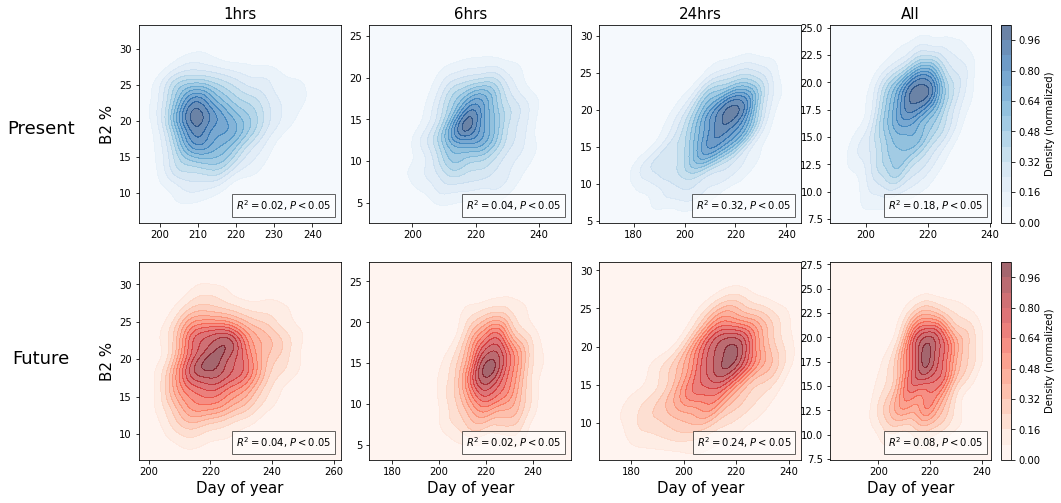

In [37]:
make_contour_plot(df_changes_byduration, df_changes_all,'B2_percentage')